## **Import Library**

In [1]:
import tensorflow as tf
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt
import os

# **Konfigurasi Dataset**

In [2]:
AUTOTUNE = tf.data.AUTOTUNE
BATCH_SIZE = 16
IMG_SIZE = (160, 160)
EPOCHS = 20
SEED = 123

# **Load dataset**

In [3]:
(ds_all, ds_test), ds_info = tfds.load(
    'cats_vs_dogs',
    split=['train', 'train[90%:100%]'],
    with_info=True,
    as_supervised=True,
    shuffle_files=True
)
full_ds = ds_all


Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Generating splits...:   0%|          | 0/1 [00:00<?, ? splits/s]

Generating train examples...: 0 examples [00:00, ? examples/s]

Shuffling /root/tensorflow_datasets/cats_vs_dogs/incomplete.PUUE2E_4.0.1/cats_vs_dogs-train.tfrecord*...:   0%…

Dataset cats_vs_dogs downloaded and prepared to /root/tensorflow_datasets/cats_vs_dogs/4.0.1. Subsequent calls will reuse this data.


# **Menghitung dan membagi dataset**

In [4]:
num_examples = ds_info.splits['train'].num_examples
print("Total images:", num_examples)


full_ds = full_ds.shuffle(1000, seed=SEED)
train_size = int(0.8 * num_examples)
val_size   = int(0.1 * num_examples)
test_size  = num_examples - train_size - val_size

ds_train = full_ds.take(train_size)
ds_remaining = full_ds.skip(train_size)
ds_val = ds_remaining.take(val_size)
ds_test = ds_remaining.skip(val_size)

print("Split sizes:", train_size, val_size, test_size)


Total images: 23262
Split sizes: 18609 2326 2327


# **Data Prepocessing**

In [5]:
def preprocess(image, label):
    # Resize and normalize to [0,1]
    image = tf.image.resize(image, IMG_SIZE)
    image = tf.cast(image, tf.float32) / 255.0
    return image, label

def augment(image, label):
    # simple augmentation: flip, rotate, brightness
    image = tf.image.random_flip_left_right(image)
    image = tf.image.random_flip_up_down(image)
    image = tf.image.random_brightness(image, max_delta=0.2)
    image = tf.image.random_contrast(image, lower=0.8, upper=1.2)
    # random crop/rescale not used to keep stable shape
    return image, label


In [6]:
ds_train = ds_train.map(preprocess, num_parallel_calls=AUTOTUNE)
ds_train = ds_train.map(augment, num_parallel_calls=AUTOTUNE)
ds_train = ds_train.shuffle(1000, seed=SEED) \
                   .batch(BATCH_SIZE) \
                   .prefetch(AUTOTUNE)

ds_val = ds_val.map(preprocess, num_parallel_calls=AUTOTUNE)
ds_val = ds_val.batch(BATCH_SIZE).cache().prefetch(AUTOTUNE)

ds_test = ds_test.map(preprocess, num_parallel_calls=AUTOTUNE)
ds_test = ds_test.batch(BATCH_SIZE).cache().prefetch(AUTOTUNE)

steps_per_epoch = train_size // BATCH_SIZE
validation_steps = max(1, val_size // BATCH_SIZE)


# **Membuat Model Sequential**

In [7]:
model = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(IMG_SIZE[0], IMG_SIZE[1], 3)),
    # Block 1
    tf.keras.layers.Conv2D(32, (3,3), activation='relu', padding='same'),
    tf.keras.layers.MaxPooling2D((2,2)),
    # Block 2
    tf.keras.layers.Conv2D(64, (3,3), activation='relu', padding='same'),
    tf.keras.layers.MaxPooling2D((2,2)),
    # Block 3
    tf.keras.layers.Conv2D(128, (3,3), activation='relu', padding='same'),
    tf.keras.layers.MaxPooling2D((2,2)),
    # Block 4 (optional deeper)
    tf.keras.layers.Conv2D(256, (3,3), activation='relu', padding='same'),
    tf.keras.layers.MaxPooling2D((2,2)),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
    loss='binary_crossentropy',
    metrics=['accuracy']
)

model.summary()


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 160, 160, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 80, 80, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 80, 80, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 40, 40, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 40, 40, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 20, 20, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 20, 20, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 10, 10, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 25600)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 25600)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │     3,276,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,665,473 (13.98 MB)

 Trainable params: 3,665,473 (13.98 MB)

 Non-trainable params: 0 (0.00 B)

# **Callbacks**

In [8]:
checkpoint_path = "best_model_ckpt.h5"
callbacks = [
    tf.keras.callbacks.ModelCheckpoint(checkpoint_path, monitor='val_accuracy', save_best_only=True, save_weights_only=False),
    tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-7),
    tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=6, restore_best_weights=True),
]

# **Proses Training**

In [9]:
history = model.fit(
    ds_train,
    epochs=EPOCHS,
    steps_per_epoch=steps_per_epoch,
    validation_data=ds_val,
    validation_steps=validation_steps,
    callbacks=callbacks
)

Epoch 1/20
1163/1163 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - accuracy: 0.5833 - loss: 0.6616

1163/1163 ━━━━━━━━━━━━━━━━━━━━ 61s 45ms/step - accuracy: 0.5833 - loss: 0.6616 - val_accuracy: 0.6819 - val_loss: 0.5803 - learning_rate: 1.0000e-04
Epoch 2/20
   1/1163 ━━━━━━━━━━━━━━━━━━━━ 50:14 3s/step - accuracy: 0.0000e+00 - loss: 0.8965

/usr/local/lib/python3.12/dist-packages/keras/src/trainers/epoch_iterator.py:116: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


1163/1163 ━━━━━━━━━━━━━━━━━━━━ 20s 15ms/step - accuracy: 0.0000e+00 - loss: 0.8965 - val_accuracy: 0.6853 - val_loss: 0.5781 - learning_rate: 1.0000e-04
Epoch 3/20
1163/1163 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - accuracy: 0.7104 - loss: 0.5628

1163/1163 ━━━━━━━━━━━━━━━━━━━━ 41s 31ms/step - accuracy: 0.7104 - loss: 0.5628 - val_accuracy: 0.7211 - val_loss: 0.5356 - learning_rate: 1.0000e-04
Epoch 4/20
   1/1163 ━━━━━━━━━━━━━━━━━━━━ 6s 6ms/step - accuracy: 0.0000e+00 - loss: 1.4800

1163/1163 ━━━━━━━━━━━━━━━━━━━━ 1s 709us/step - accuracy: 0.0000e+00 - loss: 1.4800 - val_accuracy: 0.7272 - val_loss: 0.5390 - learning_rate: 1.0000e-04
Epoch 5/20
1162/1163 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.7352 - loss: 0.5304

1163/1163 ━━━━━━━━━━━━━━━━━━━━ 41s 34ms/step - accuracy: 0.7352 - loss: 0.5304 - val_accuracy: 0.7677 - val_loss: 0.4789 - learning_rate: 1.0000e-04
Epoch 6/20
1163/1163 ━━━━━━━━━━━━━━━━━━━━ 1s 625us/step - accuracy: 0.0000e+00 - loss: 1.5575 - val_accuracy: 0.7539 - val_loss: 0.4862 - learning_rate: 1.0000e-04
Epoch 7/20
1161/1163 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - accuracy: 0.7564 - loss: 0.4990

1163/1163 ━━━━━━━━━━━━━━━━━━━━ 82s 35ms/step - accuracy: 0.7564 - loss: 0.4990 - val_accuracy: 0.7935 - val_loss: 0.4449 - learning_rate: 1.0000e-04
Epoch 8/20
1163/1163 ━━━━━━━━━━━━━━━━━━━━ 1s 666us/step - accuracy: 1.0000 - loss: 0.0466 - val_accuracy: 0.7918 - val_loss: 0.4456 - learning_rate: 1.0000e-04
Epoch 9/20
1163/1163 ━━━━━━━━━━━━━━━━━━━━ 71s 26ms/step - accuracy: 0.7862 - loss: 0.4609 - val_accuracy: 0.7884 - val_loss: 0.4473 - learning_rate: 1.0000e-04
Epoch 10/20
1163/1163 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 1.0000 - loss: 0.1596 - val_accuracy: 0.7823 - val_loss: 0.4535 - learning_rate: 1.0000e-04
Epoch 11/20
1163/1163 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - accuracy: 0.8067 - loss: 0.4228

1163/1163 ━━━━━━━━━━━━━━━━━━━━ 41s 27ms/step - accuracy: 0.8067 - loss: 0.4228 - val_accuracy: 0.8366 - val_loss: 0.3885 - learning_rate: 5.0000e-05
Epoch 12/20
   1/1163 ━━━━━━━━━━━━━━━━━━━━ 6s 6ms/step - accuracy: 1.0000 - loss: 0.5118

1163/1163 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 1.0000 - loss: 0.5118 - val_accuracy: 0.8371 - val_loss: 0.3878 - learning_rate: 5.0000e-05
Epoch 13/20
1162/1163 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - accuracy: 0.8158 - loss: 0.4002

1163/1163 ━━━━━━━━━━━━━━━━━━━━ 41s 33ms/step - accuracy: 0.8158 - loss: 0.4002 - val_accuracy: 0.8397 - val_loss: 0.3745 - learning_rate: 5.0000e-05
Epoch 14/20
   1/1163 ━━━━━━━━━━━━━━━━━━━━ 6s 6ms/step - accuracy: 1.0000 - loss: 0.0320

1163/1163 ━━━━━━━━━━━━━━━━━━━━ 1s 773us/step - accuracy: 1.0000 - loss: 0.0320 - val_accuracy: 0.8422 - val_loss: 0.3745 - learning_rate: 5.0000e-05
Epoch 15/20
1162/1163 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - accuracy: 0.8242 - loss: 0.3979

1163/1163 ━━━━━━━━━━━━━━━━━━━━ 41s 32ms/step - accuracy: 0.8242 - loss: 0.3979 - val_accuracy: 0.8427 - val_loss: 0.3759 - learning_rate: 5.0000e-05
Epoch 16/20
   1/1163 ━━━━━━━━━━━━━━━━━━━━ 8s 7ms/step - accuracy: 1.0000 - loss: 0.0813

1163/1163 ━━━━━━━━━━━━━━━━━━━━ 1s 989us/step - accuracy: 1.0000 - loss: 0.0813 - val_accuracy: 0.8431 - val_loss: 0.3752 - learning_rate: 5.0000e-05
Epoch 17/20
1161/1163 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - accuracy: 0.8320 - loss: 0.3745

1163/1163 ━━━━━━━━━━━━━━━━━━━━ 41s 33ms/step - accuracy: 0.8320 - loss: 0.3745 - val_accuracy: 0.8500 - val_loss: 0.3569 - learning_rate: 2.5000e-05
Epoch 18/20
1163/1163 ━━━━━━━━━━━━━━━━━━━━ 1s 931us/step - accuracy: 1.0000 - loss: 0.1764 - val_accuracy: 0.8491 - val_loss: 0.3572 - learning_rate: 2.5000e-05
Epoch 19/20
1163/1163 ━━━━━━━━━━━━━━━━━━━━ 35s 26ms/step - accuracy: 0.8385 - loss: 0.3719 - val_accuracy: 0.8427 - val_loss: 0.3552 - learning_rate: 2.5000e-05
Epoch 20/20
1163/1163 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 1.0000 - loss: 0.0208 - val_accuracy: 0.8427 - val_loss: 0.3561 - learning_rate: 2.5000e-05


# **Evaluasi training dan testing set**

In [10]:
test_loss, test_acc = model.evaluate(ds_test, verbose=2)
print(f"Test accuracy: {test_acc:.4f}, Test loss: {test_loss:.4f}")

train_eval_ds = full_ds.take(train_size).map(preprocess).batch(BATCH_SIZE).prefetch(AUTOTUNE)
train_loss, train_acc = model.evaluate(train_eval_ds, verbose=2)
print(f"Train accuracy: {train_acc:.4f}, Train loss: {train_loss:.4f}")


146/146 - 21s - 145ms/step - accuracy: 0.8457 - loss: 0.3644
Test accuracy: 0.8457, Test loss: 0.3644
1164/1164 - 25s - 21ms/step - accuracy: 0.8518 - loss: 0.3464
Train accuracy: 0.8518, Train loss: 0.3464


# **Plot Akurasi & loss**

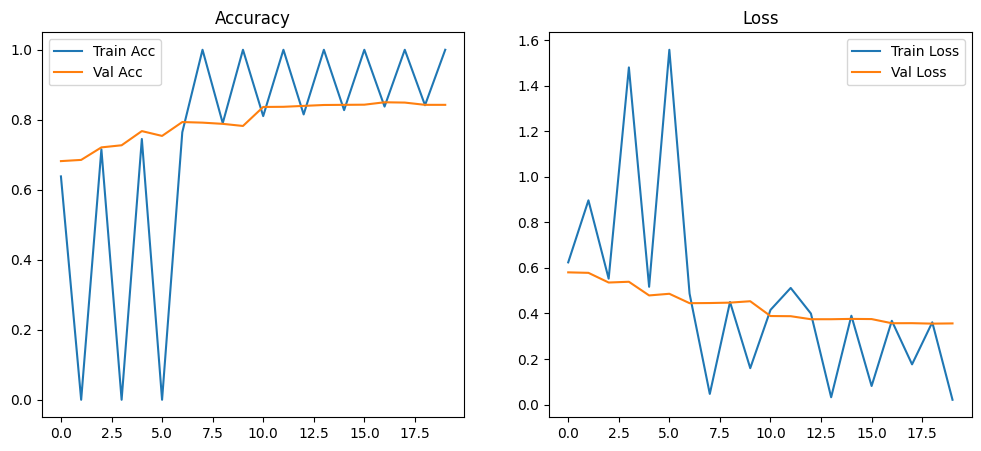

In [11]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs_range = range(len(acc))

plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.plot(epochs_range, acc, label='Train Acc')
plt.plot(epochs_range, val_acc, label='Val Acc')
plt.title('Accuracy')
plt.legend()

plt.subplot(1,2,2)
plt.plot(epochs_range, loss, label='Train Loss')
plt.plot(epochs_range, val_loss, label='Val Loss')
plt.title('Loss')
plt.legend()
plt.show()


## **Menyimpan model ke format savemodel**

In [16]:
# 10) Save model: SavedModel (format .pb + variables/)
saved_model_path = "Saved_Model/cats_vs_dogs_savedmodel"
model.export(saved_model_path)

print("SavedModel exported to:", saved_model_path)


Saved artifact at 'Saved_Model/cats_vs_dogs_savedmodel'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 160, 160, 3), dtype=tf.float32, name='keras_tensor')
Output Type:
  TensorSpec(shape=(None, 1), dtype=tf.float32, name=None)
Captures:
  136423555345168: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136423455560464: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136423455561040: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136423455558928: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136423455561616: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136423455558544: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136423455559120: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136423455560656: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136423455562000: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136423455562768: TensorSpec(shape=(), dtype=tf.resource, name=Non

## **Menyimpan ke format TFLite**

In [20]:
# Simpan ke format Keras
model.save("best_model.keras")

# Load dari Keras format
loaded_model = tf.keras.models.load_model("best_model.keras")

# Convert ke TFLite
converter = tf.lite.TFLiteConverter.from_keras_model(loaded_model)
tflite_model = converter.convert()

# Simpan TFLite
with open("model_cats_vs_dogs.tflite", "wb") as f:
    f.write(tflite_model)

print("TFLite model saved to: model_cats_vs_dogs.tflite")


/usr/local/lib/python3.12/dist-packages/keras/src/saving/saving_lib.py:802: UserWarning: Skipping variable loading for optimizer 'rmsprop', because it has 14 variables whereas the saved optimizer has 26 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


Saved artifact at '/tmp/tmp5cjjgd47'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 160, 160, 3), dtype=tf.float32, name='input_layer')
Output Type:
  TensorSpec(shape=(None, 1), dtype=tf.float32, name=None)
Captures:
  136423457238736: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136423531564880: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136423531568336: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136423531569488: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136423531568144: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136423531568528: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136423531567760: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136423531567952: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136423531567184: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136423531568912: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136423531566608

## **Menyimpan ke format TFjs**

In [24]:
!pip install tensorflowjs

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 89.1/89.1 kB 4.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.0/53.0 kB 4.0 MB/s eta 0:00:00
  Attempting uninstall: packaging
    Found existing installation: packaging 25.0
    Uninstalling packaging-25.0:
      Successfully uninstalled packaging-25.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
xarray 2025.9.0 requires packaging>=24.1, but you have packaging 23.2 which is incompatible.
google-cloud-bigquery 3.36.0 requires packaging>=24.2.0, but you have packaging 23.2 which is incompatible.
db-dtypes 1.4.3 requires packaging>=24.2.0, but you have packaging 23.2 which is incompatible.


In [25]:
import tensorflowjs as tfjs
import tensorflow as tf

# Load model H5
model = tf.keras.models.load_model("model_cats_vs_dogs.h5")

# Simpan ke TFJS
tfjs.converters.save_keras_model(model, "tfjs_model_cats_vs_dogs")

print("✅ TFJS model saved in folder: tfjs_model_cats_vs_dogs")


failed to lookup keras version from the file,
    this is likely a weight only file
✅ TFJS model saved in folder: tfjs_model_cats_vs_dogs


In [22]:
!tensorflowjs_converter \
    --input_format=keras \
    --output_format=tfjs_layers_model \
    model_cats_vs_dogs.h5 \
    tfjs_model_cats_vs_dogs


/bin/bash: line 1: tensorflowjs_converter: command not found
